<a href="https://colab.research.google.com/github/ereinha/SineKAN/blob/main/SineKAN_Continual_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import matplotlib.pyplot as plt
from sine_kan import *
import torch
import numpy as np
from tqdm import tqdm

In [ ]:
# Based on https://github.com/quiqi/relu_kan/blob/main/catastrophic_forgetting.py

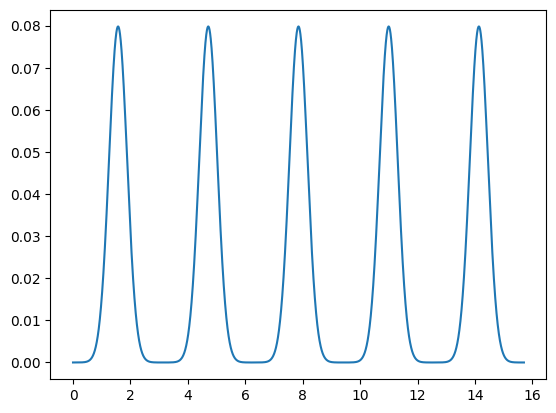

In [10]:
def gs(x, sigma = 5):
    x = (x - np.min(x)) / (np.max(x) - np.min(x))
    x = (x - 0.5) * 2
    return np.multiply(np.power(np.sqrt(2 * np.pi) * sigma, -1), np.exp(-np.power(x, 2) / 2 * sigma ** 2))


xs = np.arange(0, 5000) / 5000 * 5 * np.pi
ys = []
for i in range(5):
    x = xs[i*1000: (i+1)*1000]
    y = gs(x)
    ys.append(y)
ys = np.concatenate(ys)
plt.plot(xs, ys)
plt.show()

In [11]:
ys = ys / 0.08
xs = xs.reshape([5000, 1, 1])
ys = ys.reshape([5000, 1, 1])
xs = torch.Tensor(xs)
ys = torch.Tensor(ys)

In [14]:
torch.manual_seed(42)
fig, axes = plt.subplots(5, 2, figsize=(12, 20), dpi=600)
plt.rcParams['font.size'] = '40'
def custom_loss(y_pred, y_true, model):
    return torch.nn.MSELoss()(y_pred, y_true) + ((model.amplitudes)**2).sum() * 0.05
sine_kan = SineKANLayer(1, 1, 'cpu', 30, is_first=True)
for i in range(5):
    opt = torch.optim.Adam(sine_kan.parameters(), lr=0.01)
    t_xs = xs[i * 1000: (i + 1) * 1000]
    t_ys = ys[i * 1000: (i + 1) * 1000]
    for e in range(250):
        sine_kan.train()
        opt.zero_grad()
        t_pred = sine_kan(t_xs)
        loss = custom_loss(t_pred, t_ys, sine_kan)
        loss.backward()
        opt.step()

    # Plotting predictions after training
    sine_kan.eval()
    pred = sine_kan(xs)

    # Left Column: Predictions during training
    axes[i, 0].plot(xs[:, 0, 0], ys[:, 0, 0], '--', color='black', label='True Values')
    axes[i, 0].plot(xs[:, 0, 0], pred.detach()[:, 0, 0], '-', color='black', label='Predictions')
    axes[i, 0].set_ylim(-0.2, 1.5)
    axes[i, 0].set_yticks([0, 1])
    if i < 4:
        axes[i, 0].set_xticks([])
    else:
        axes[i, 0].set_xticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi, 5*np.pi])
        axes[i, 0].set_xticklabels([r"$0$", r"$\pi$", r"$2\pi$", r"$3\pi$", r"$4\pi$", r"$5\pi$"])

    # Right Column: Ground truth values
    axes[i, 1].plot(xs[:, 0, 0], ys[:, 0, 0], '--', color='black', label='True Values (Overall)')
    axes[i, 1].plot(t_xs[:, 0, 0], t_ys[:, 0, 0], '-', color='black', label='True Values (Batch)')
    axes[i, 1].set_ylim(-0.2, 1.5)
    axes[i, 1].set_yticks([])
    if i < 4:
        axes[i, 1].set_xticks([])
    else:
        axes[i, 1].set_xticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi, 5*np.pi])
        axes[i, 1].set_xticklabels([r"$0$", r"$\pi$", r"$2\pi$", r"$3\pi$", r"$4\pi$", r"$5\pi$"])

# Remove spaces between subplots to create a connected look
plt.subplots_adjust(hspace=0.0, wspace=0.0)

plt.tight_layout()
plt.savefig('./saved_results/continual_learning.jpg', dpi=600)  # Save as a single PDF file
plt.show()

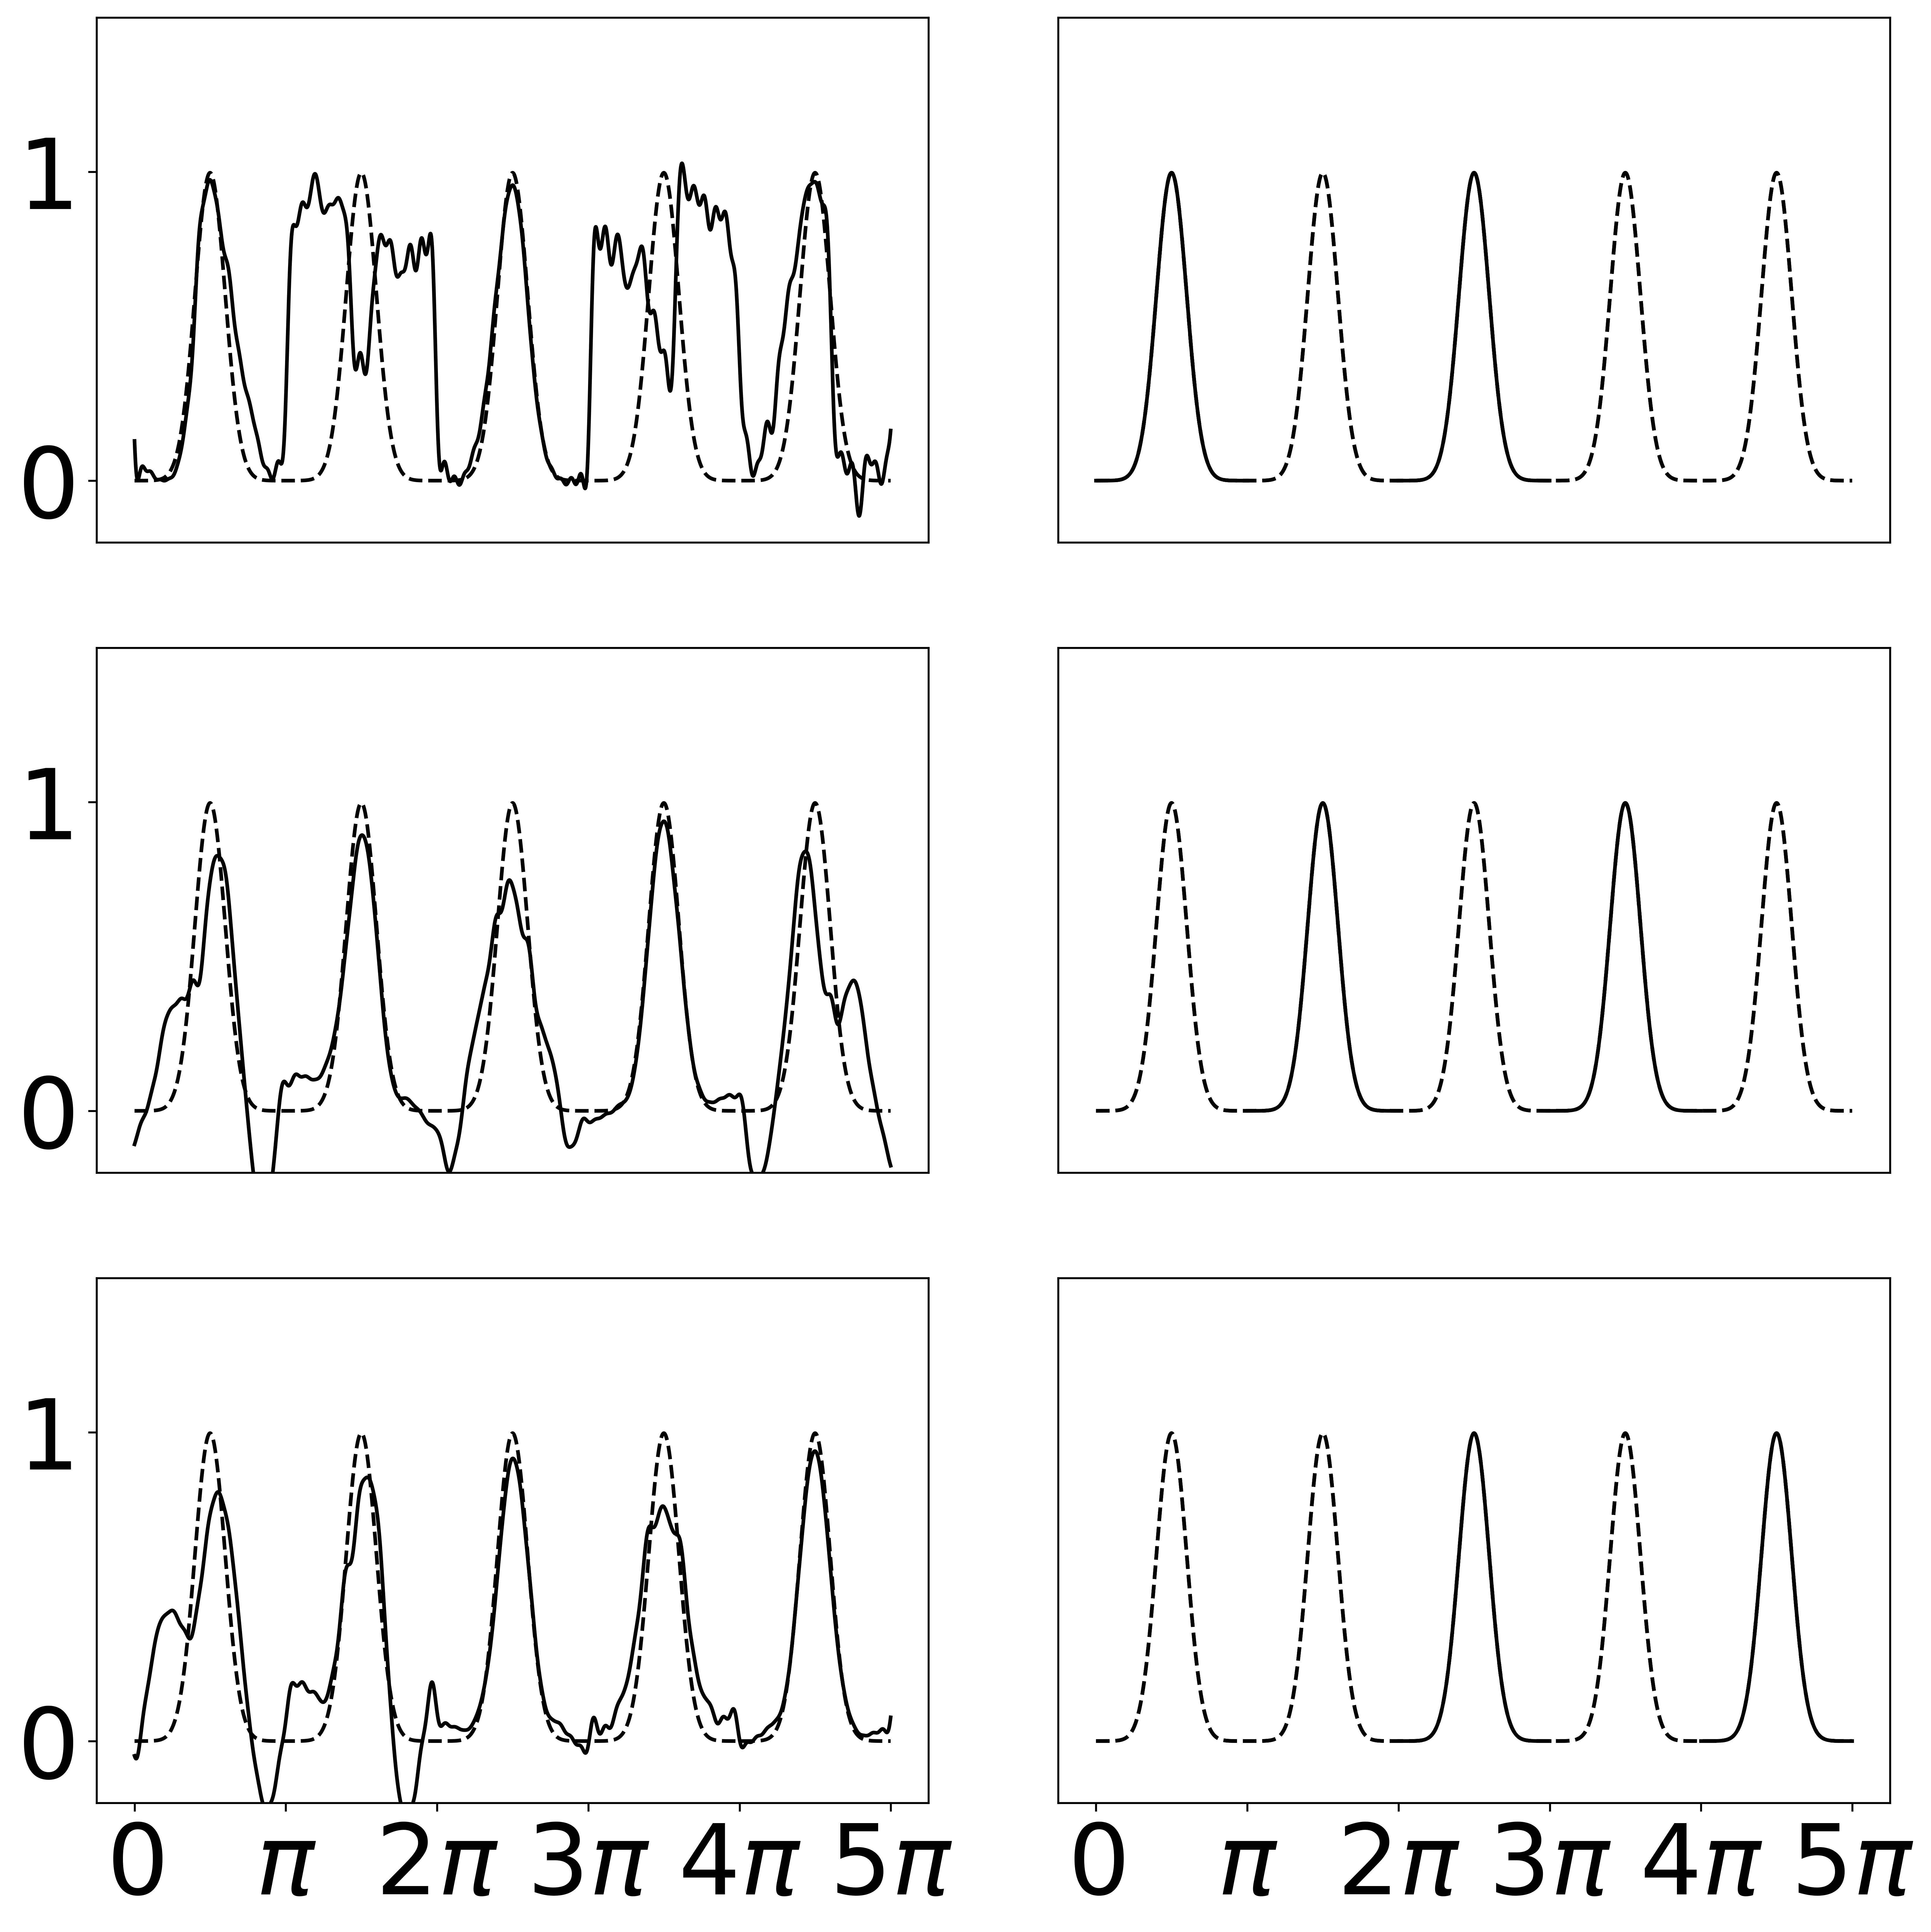

In [13]:
torch.manual_seed(42)
fig, axes = plt.subplots(3, 2, figsize=(12, 12), dpi=600)
sine_kan = SineKANLayer(1, 1, 'cpu', 30, is_first=True)
plt.rcParams['font.size'] = '40'

for i in range(3):
    opt = torch.optim.Adam(sine_kan.parameters(), lr=0.004)
    def custom_loss(y_pred, y_true, model):
        return torch.nn.MSELoss()(y_pred, y_true) + ((model.amplitudes)**2).sum() * 0.05
    if i == 2:
        t_xs = torch.cat([xs[i * 1000: (i + 1) * 1000], xs[(i + 2) * 1000: (i + 3) * 1000]])
        t_ys = torch.cat([ys[i * 1000: (i + 1) * 1000], ys[(i + 2) * 1000: (i + 3) * 1000]])
    else:
        t_xs = torch.cat([xs[i * 1000: (i + 1) * 1000], xs[(i + 2) % 5 * 1000: (i + 3) % 5 * 1000]])
        t_ys = torch.cat([ys[i * 1000: (i + 1) * 1000], ys[(i + 2) % 5 * 1000: (i + 3) % 5 * 1000]])
    for e in range(250):
        sine_kan.train()
        opt.zero_grad()
        t_pred = sine_kan(t_xs)
        loss = custom_loss(t_pred, t_ys, sine_kan)
        loss.backward()
        opt.step()

    # Plotting predictions after training
    sine_kan.eval()
    pred = sine_kan(xs)

    # Left Column: Predictions during training
    axes[i, 0].plot(xs[:, 0, 0], ys[:, 0, 0], '--', color='black', label='True Values')
    axes[i, 0].plot(xs[:, 0, 0], pred.detach()[:, 0, 0], '-', color='black', label='Predictions')
    axes[i, 0].set_ylim(-0.2, 1.5)
    axes[i, 0].set_yticks([0, 1])
    if i < 2:
        axes[i, 0].set_xticks([])
    else:
        axes[i, 0].set_xticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi, 5*np.pi])
        axes[i, 0].set_xticklabels([r"$0$", r"$\pi$", r"$2\pi$", r"$3\pi$", r"$4\pi$", r"$5\pi$"])

    # Right Column: Ground truth values
    axes[i, 1].plot(xs[:, 0, 0], ys[:, 0, 0], '--', color='black', label='True Values (Overall)')
    axes[i, 1].plot(xs[:, 0, 0], ys[:, 0, 0], '--', color='black', label='True Values (Overall)')
    axes[i, 1].plot(t_xs[:1000, 0, 0], t_ys[:1000, 0, 0], '-', color='black', label='True Values (Batch)')
    axes[i, 1].plot(t_xs[1000:, 0, 0], t_ys[1000:, 0, 0], '-', color='black', label='True Values (Batch)')
    axes[i, 1].set_ylim(-0.2, 1.5)
    axes[i, 1].set_yticks([])
    if i < 2:
        axes[i, 1].set_xticks([])
    else:
        axes[i, 1].set_xticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi, 5*np.pi])
        axes[i, 1].set_xticklabels([r"$0$", r"$\pi$", r"$2\pi$", r"$3\pi$", r"$4\pi$", r"$5\pi$"])

# Remove spaces between subplots to create a connected look
plt.subplots_adjust(hspace=0.0, wspace=0.0)

plt.tight_layout()
plt.savefig('./saved_results/continual_learning_spaced.jpg', dpi=600)  # Save as a single PDF file
plt.show()